# Projet

In [1]:
from scipy.fft import fft
import numpy as np
import matplotlib.pyplot as plt

import glob
import torch 
import librosa
from os import listdir
import re
import audioread


In [2]:
dict_classes = {
    0: 'portuguese',
    1: 'china',
    2: 'french',
    3: 'quebec',
    4: 'maroc',
    5: 'japon',
    6: 'american',
    7: 'english',
    8: 'korean',
    9: 'spain',
    10: 'italy',
    11: 'tunis'
    }
list_genres = ['M', 'F']

In [3]:
import glob
import re
import librosa
import numpy as np

# Initialisation des listes et des variables
data = []  # Contiendra les données audio
labels = []  # Contiendra les labels des langues
genres = []  # Contiendra les genres (M/F)
names = []  # Contiendra les noms des fichiers
min_duration = None  # Durée minimale en échantillons

# Parcourir tous les fichiers MP3 dans le dossier 'clips'
for file_name in glob.glob('clips/*.mp3'):
    try:
        # Ajout des noms de fichiers
        names.append(file_name)
        
        # Chargement de l'audio avec librosa
        audio, sr = librosa.load(file_name, sr=None)  # sr=None pour conserver la fréquence d'échantillonnage d'origine
        
        # Ajout des données audio
        data.append(audio)
        
        # Calcul de la durée minimale
        if min_duration is None or len(audio) < min_duration:
            print(file_name)
            min_duration = len(audio)
        
        # # Création du vecteur des labels des langues
        # for i, word in enumerate(languages):
        #     if re.search(word, file_name, re.IGNORECASE):  # Recherche insensible à la casse
        #         labels.append(i)
        #         break  # Une seule correspondance par fichier

        for key, word in dict_classes.items():
            if re.search(word, file_name, re.IGNORECASE):  # Recherche insensible à la casse
                labels.append(key)
                break  # Une seule correspondance par fichier
        
        # Création du vecteur des genres
        for genre in list_genres:
            if re.search(genre, file_name, re.IGNORECASE):  # Recherche insensible à la casse
                genres.append(genre)
                break  # Une seule correspondance par fichier
        
    except Exception as e:
        print(f"Erreur lors du traitement du fichier {file_name}: {e}")

# Conversion en tableaux NumPy pour une manipulation plus facile
data = np.array(data, dtype=object)  # Utiliser dtype=object pour des séquences audio de différentes longueurs
labels = np.array(labels)
genres = np.array(genres)

# Affichage des informations finales
print(f"La plus petite durée d'enregistrement est {min_duration} échantillons.")
print(f"la fréquence d'échantillonnage est {sr} Hz.")
print(f"Le nombre de fichiers traités est {len(data)}.")


clips/quebec_H_27.mp3
clips/tunis_H_17.mp3
La plus petite durée d'enregistrement est 176400 échantillons.
la fréquence d'échantillonnage est 48000 Hz.
Le nombre de fichiers traités est 1200.


In [4]:
def trim(record, min_duration):
    half_duration = min_duration//2

    # First, we compute the barycenter of energy along time. We interpret it as the moment when the word appears
    barycenter = int(np.floor(np.multiply(np.power(record,2),np.arange(0,record.shape[0],1)).sum()/np.power(record,2).sum()))

    # Second, we adjust the barycenter to be in the index range
    if barycenter-half_duration < 0:
        barycenter += half_duration-barycenter
    if barycenter+half_duration >= record.shape[0]:
        barycenter -= barycenter+half_duration - record.shape[0]
    
    # Finally, we trim the recording around the barycenter 
    return record[barycenter-half_duration:barycenter+half_duration]

In [5]:
X = np.empty((len(data),min_duration))
for i in range(len(data)):
    X[i,:] = trim(data[i], min_duration)

y = np.array(labels)
print(f'Shape of inputs X is{X.shape} and size of targets class is {y.shape}')

Shape of inputs X is(1200, 176400) and size of targets class is (1200,)


### Réduction de dimension

#### STFT

In [6]:
from sklearn.preprocessing import StandardScaler

X_scale = StandardScaler().fit_transform(X)

Shape of the spectrogram is (1025, 345)


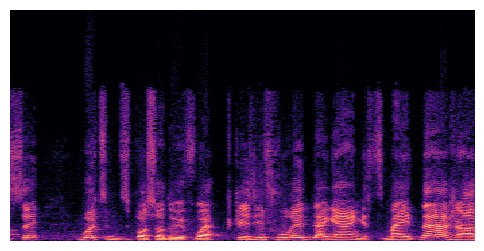

In [7]:
# Calculer le spectrogramme
stft_result = librosa.stft(X_scale[0], n_fft=2048, hop_length=512)
spectrogram = np.abs(stft_result)
spectrogram_db = librosa.amplitude_to_db(spectrogram, ref=np.max)

# Créer le graphique du spectrogramme (sans axes ni titre)
plt.figure(figsize=(6, 3))
plt.axis('off')  # Désactiver les axes
librosa.display.specshow(spectrogram_db, sr=None, hop_length=512,
                            x_axis=None, y_axis=None, cmap="magma")

print(f"Shape of the spectrogram is {spectrogram_db.shape}")

In [8]:
# obtenir X_stft
X_stft = np.empty((X_scale.shape[0], spectrogram_db.shape[0], spectrogram_db.shape[1]))
for i in range(X_scale.shape[0]):
    stft_result = librosa.stft(X_scale[i], n_fft=2048, hop_length=512)
    spectrogram = np.abs(stft_result)
    spectrogram_db = librosa.amplitude_to_db(spectrogram, ref=np.max)
    X_stft[i] = spectrogram_db

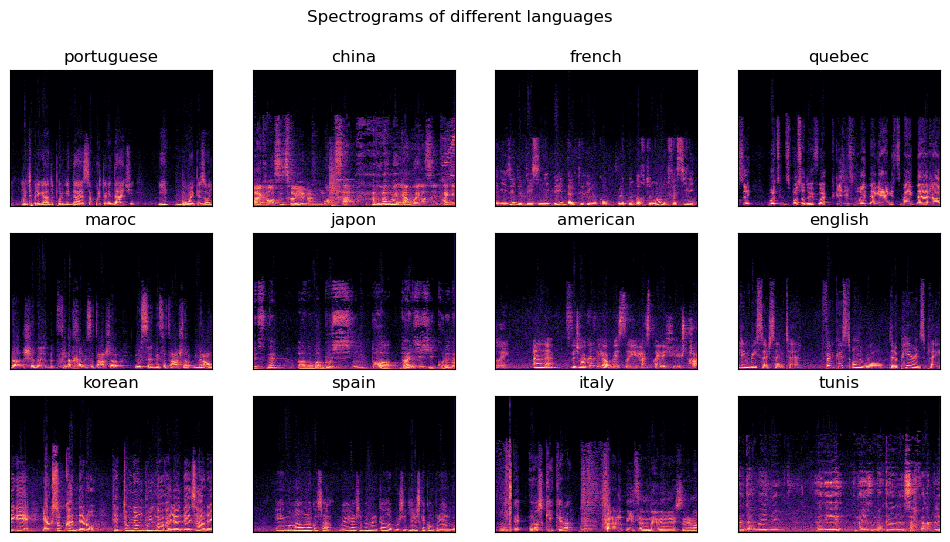

In [9]:
# afficher sur la même figure un spectrogramme pour chaque langue
plt.figure(figsize=(12, 6))
plt.axis('off')
for i in range(12):
    plt.subplot(3, 4, i+1)
    index = np.where(y == i)[0][0]
    plt.title(dict_classes[i])
    librosa.display.specshow(X_stft[index], sr=None, hop_length=512,
                             x_axis=None, y_axis=None, cmap="magma")

plt.suptitle("Spectrograms of different languages")
plt.show()

### Datasets

In [10]:
from torch.utils.data import Dataset, DataLoader


class AudioDataset(Dataset):
    def __init__(self, data, labels, genres, names, mode=None):
        self.data = []
        self.labels = []
        self.genres = []

        for i, file_name in enumerate(names):
            number = file_name.split('.')[0].split('_')[-1]
            if mode == 'train':
                if int(number) <= 40:
                    self.data.append(data[i])
                    self.labels.append(labels[i])
                    self.genres.append(genres[i])
            elif mode == 'val':
                if 41 <= int(number) <= 45:
                    self.data.append(data[i])
                    self.labels.append(labels[i])
                    self.genres.append(genres[i])
            elif mode == 'test':
                if int(number) >= 46:
                    self.data.append(data[i])
                    self.labels.append(labels[i])
                    self.genres.append(genres[i])

        self.data = np.array(self.data)
        self.labels = np.array(self.labels)
        self.genres = np.array(self.genres)
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx], self.genres[idx]

In [11]:
train_dataset = AudioDataset(X_stft, y, genres, names, mode='train')
val_dataset = AudioDataset(X_stft, y, genres, names, mode='val')
test_dataset = AudioDataset(X_stft, y, genres, names, mode='test')

In [12]:
print(f"Taille du dataset d'entraînement : {len(train_dataset)}")
print(f"Taille du dataset de validation : {len(val_dataset)}")
print(f"Taille du dataset de test : {len(test_dataset)}")

Taille du dataset d'entraînement : 960
Taille du dataset de validation : 120
Taille du dataset de test : 120


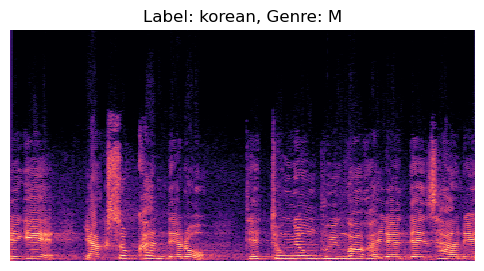

In [13]:
# afficher un exemple de données de train
data, label, genre = train_dataset.__getitem__(7)
plt.figure(figsize=(6, 3))
plt.axis('off')
librosa.display.specshow(data, sr=None, hop_length=512,
                         x_axis=None, y_axis=None, cmap="magma")
plt.title(f"Label: {dict_classes[label]}, Genre: {genre}")
plt.show()

In [18]:
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, drop_last=True, num_workers=4)
val_dataloader = DataLoader(val_dataset, batch_size=32, num_workers=4)
test_dataloader = DataLoader(test_dataset, batch_size=32, num_workers=4)

### Entrainement

##### Modèle

On va utiliser un modèle LeNet

In [20]:
# modèle LeNet
import torch.nn as nn
import torch.nn.functional as F

class LeNet(nn.Module):
    def __init__(self, num_channels, num_classes):
        super(LeNet, self).__init__()
        self.num_channels = num_channels
        self.num_classes = num_classes
        self.conv1 = nn.Conv2d(self.num_channels, 6, 5, padding=2)
        self.conv2 = nn.Conv2d(6, 16, 5)

        self.fc1_input_size = self._calculate_fc1_input_size()

        self.fc1 = nn.Linear(self.fc1_input_size, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, self.num_classes)

    def _calculate_fc1_input_size(self):
        x = torch.randn(1, self.num_channels, 1025, 345)
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), (2, 2))
        return x.numel() # Total number of elements in the tensor

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), (2, 2))
        x = x.view(-1, self.fc1_input_size)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [21]:
#model summary
from torchsummary import summary
print((spectrogram_db.shape[0], spectrogram_db.shape[1]))
model = LeNet(num_channels=1, num_classes=12)
print(summary(model, (1, spectrogram_db.shape[0], spectrogram_db.shape[1])))


(1025, 345)
Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 6, 1025, 345]        156
├─Conv2d: 1-2                            [-1, 16, 508, 168]        2,416
├─Linear: 1-3                            [-1, 120]                 40,965,240
├─Linear: 1-4                            [-1, 84]                  10,164
├─Linear: 1-5                            [-1, 12]                  1,020
Total params: 40,978,996
Trainable params: 40,978,996
Non-trainable params: 0
Total mult-adds (M): 298.85
Input size (MB): 1.35
Forward/backward pass size (MB): 26.61
Params size (MB): 156.32
Estimated Total Size (MB): 184.28
Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 6, 1025, 345]        156
├─Conv2d: 1-2                            [-1, 16, 508, 168]        2,416
├─Linear: 1-3                            [-1, 120]                 40,965,240
├─Linear: 1-4        

In [25]:
from tqdm import tqdm

nb_epochs = 20

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.1)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(nb_epochs):
    model.train()
    train_loss = 0
    correct = 0
    total = 0
    for data, labels, genres in tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{nb_epochs}"):
        data, labels = data.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(data.unsqueeze(1).float())
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    
    train_losses.append(train_loss / len(train_dataloader))
    train_accuracies.append(100 * correct / total)

    model.eval()
    val_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for data, labels, genres in tqdm(val_dataloader, desc=f"Validation {epoch+1}/{nb_epochs}"):
            data, labels = data.to(device), labels.to(device)
            outputs = model(data.unsqueeze(1).float())
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    
    val_losses.append(val_loss / len(val_dataloader))
    val_accuracies.append(100 * correct / total)

    print(f"Epoch {epoch+1}/{nb_epochs}, Train Loss: {train_losses[-1]:.4f}, Train Accuracy: {train_accuracies[-1]:.2f}%, Val Loss: {val_losses[-1]:.4f}, Val Accuracy: {val_accuracies[-1]:.2f}%")
    scheduler.step()

Epoch 1/20:  20%|██        | 6/30 [00:24<01:39,  4.14s/it]